# [개념 필사]

# CHAPTER 04 <분류>

## 9. 캐글 산탄데르 고객 만족 예측

> 개요
- 370개 피처
- TARGET = 1 (불만족), 0 (만족)
- 성능 평가: ROC-AUC (만족이 많기 때문)


(1) 데이터 전처리

* 피처 371개 (float 111개 + int 260개), 결측치 없음
* 불만족 비율 4%
* var3 칼럼의 -999999 -> 2(최빈값)
* ID 피처 드롭
* 클래스 데이터세트, 피처 데이터 세트 분리
* 학습 데이터 세트, 테스트 데이터 세트 분리 (비대칭 데이터 분포 고려)
* 학습 데이터세트를 재분리 (학습/검증) => 조기 중단 위해

(2) XGBoost 모델 학습, 하이퍼 파라미터 튜닝

* ROC-AUC <= eval_metric='auc' 로 지정 ; **ROC-AUC 약 0.8417**

* HyperOpt 이용해 하이퍼 파라미터 튜닝
> 목적함수생성: 3 Fold 교차 검증 -> ROC-AUC 평균값 반환x(-1)  / 최적 하이퍼 파라미터 도출 -> XGBClassifier 재학습  **ROC-AUC 약 0.8448**(약간 개선)

* 피처 중요도 시각화: var38, var15

(3) LightGBM 모델 학습, 하이퍼 파라미터 튜닝

**ROC AUC 약 0.8384**
* XGBoost 보다 시간 적게 걸림


* HyperOpt 이용해 하이퍼 파라미터 튜닝: 튜닝 대상(num_leaves, max_depth, min_child_samples, subsample, learning_rate)
> 목적함수생성: 위 XGBoost 와 유사 (LGBMClassifier 로 변경)  / 최적 하이퍼 파라미터 도출 -> LightGBM 재학습  **ROC-AUC 약 0.8448**

## 10. 분류 실습 - 캐글 신용카드 사기 검출

> 개요
- Class = 1 (**0.172%**)(사기 신용카드 트랜잭션), 0 (정상 신용카드 트랜잭션) << 매우 비대칭적 분포

**언더 샘플링 & 오버 샘플링**

배경: 불균형한 레이블 분포(이상 레이블 건수 <<< 정상 레이블 건수) 일 때, 예측성능문제 발생 / 적절한 학습 데이터 확보 필요!

[언더 샘플링] 많은 레이블을 가진 데이터 세트를 적은 레이블을 가진 데이터 세트 수준으로 감소
* 과도한 감소로 인해 제대로 학습 안될 수도 있음

[오버 샘플링] 적은 데이터 세트를 증식시켜 충분한 데이터 확보 / 주로 이걸 사용
* 원본데이터들을 살짝 변경하여 증식 (SMOTE)
```
SMOTE 구현 패키지: imbalanced-learn
```

(1) 데이터 일차 가공 및 모델 학습, 예측, 평가

* Time 피처 드롭
* Amount 피처: 신용카드 트랜잭션 금액
* 피처 31개 (float 30개 + int 1개), 결측치 없음
* 함수 생성

> get_preprocessed_df() - 데이터 가공하여 반환하는 함수

> get_train_test_dataset(): 학습/테스트 데이터세트 반환 함수

> get_model_train_eval(): 반복적으로 모델 변경해 학습, 예측, 평가 수행하기 위한 함수

* 모델학습: 로지스틱회귀, LightGBM (불균형 분포! **boost_from_average=False** 설정 필수)

(2) 데이터 분포도 변환 후 학습, 예측, 평가

* Amount: 꼬리 긴 형태 -> 1. 표준 정규 분포 형태로 변환 / 2. 로그 변환
* 로지스틱회귀, LightGBM 수행

(3) 이상치 데이터 제거 후 학습, 예측, 평가

이상치 데이터(아웃라이어): 전체 데이터의 패턴에서 벗어난 이상 값

* IQR 방식 적용: Q1-1.5Q1, Q3+1.5Q3 벗어나는 값을 이상치로 간주
* 레이블과 가장 상관성이 높은 피처 위주로 이상치 검출 (corr()사용) -> V14, V17
> get_outlier(): 이상치 검출 함수 -> get_preprocessed_df() 함수에 추가


로지스틱회귀, LightGBM 수행: 두 모델에서 모두 예측 성능 크게 향상!

(4) SMOTE 오버 샘플링 적용 후 학습, 예측, 평가

* 주의점: 학습 데이터세트만 오버샘플링 해야함
* fit_resample() 메서드 이용

* 로지스틱 회귀 수행: 올바른 예측 모델 X

* LightGBM 수행

결론: SMOTE 적용 시, 재현율은 증가, 정밀도 감소 / 재현율 지표를 높이는 것이 주요 목적일 때 사용하기


요약)
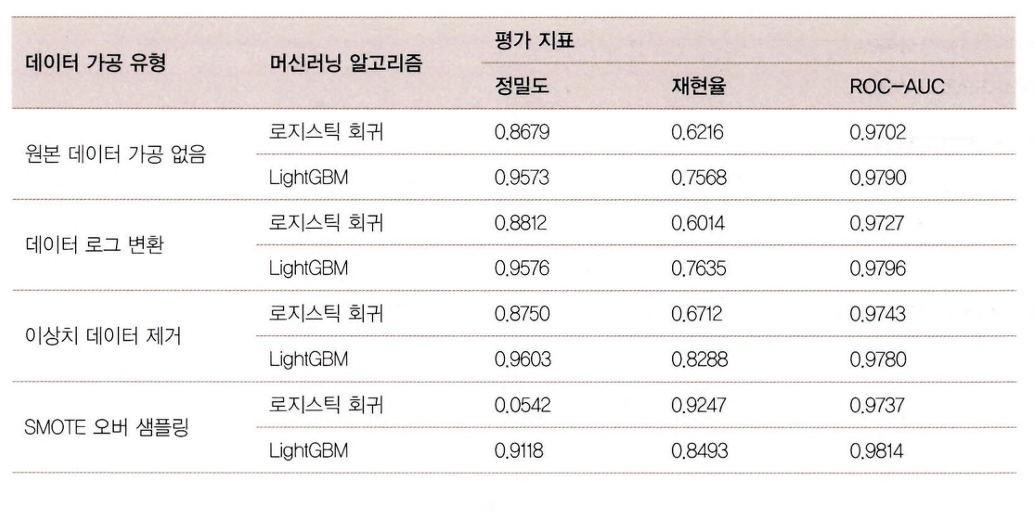

# [코드 필사]

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 산탄데르 고객 실습

1. 데이터 전처리

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import warnings

warnings.filterwarnings('ignore')
cust_df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train_santander.csv',
                    encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [3]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [4]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET']==1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt/total_cnt)))

TARGET
0    73012
1     3008
Name: count, dtype: int64
unsatisfied 비율은 0.04


In [5]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [6]:
cust_df['var3'].replace(-999999,2, inplace=True)
cust_df.drop('ID', axis=1, inplace=True)

# 피처, 레이블 데이터세트 분리 / 레이블 칼럼은 df의 맨 마지막에 위치했으므로 칼럼 위치 -1로 분리
X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                    test_size=0.2, random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape, X_test.shape))

print('학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)
학습 세트 레이블 값 분포 비율
TARGET
0    0.960964
1    0.039036
Name: count, dtype: float64

 테스트 세트 레이블 값 분포 비율
TARGET
0    0.9583
1    0.0417
Name: count, dtype: float64


In [8]:
from re import X
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

2. XGBoost 모델 학습, 하이퍼 파라미터 튜닝

In [9]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# nestimator 500, random state 설정
# 성능 평가 지표 auc, 조기중단파라미터 100
xgb_clf = XGBClassifier(n_estimators=500, learning_rate=0.05, random_state=156,
                        eval_metric="auc",
                        early_stopping_rounds=100)
xgb_clf.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr),(X_val, y_val)],verbose=False)

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

ROC AUC: 0.8417


In [10]:
# 검색공간 설정

from hyperopt import hp

xgb_search_space = {'max_depth':hp.quniform('max_depth',5, 15,1),
                    'min_child_weight':hp.quniform('min_child_weight',1,6,1),
                    'learning_rate':hp.uniform('learning_rate',0.01,0.2),
                    'colsample_bytree':hp.uniform('colsample_bytree',0.5,0.95)}

In [11]:
# 목적 함수 생성

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

# fmin()에서 호출 시 search_space 값으로 XGBClassifier 교차 검증 학습 후 -1*roc_auc 평균값 반환
# 조기중단 30회
def objective_func(search_space):
  xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                          min_child_weight=int(search_space['min_child_weight']),
                          colsample_bytree=search_space['colsample_bytree'],
                          learning_rate=search_space['learning_rate'],
                          early_stopping_rounds= 30,
                          eval_metric="auc")
  # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
  roc_auc_list =[ ]

  # 3개 k-fold 방식 적용
  kf=KFold(n_splits=3)
  # X_train을 다시 학습과 검증용 데이터로 분리
  for tr_index, val_index in kf.split(X_train):
    # kf.split(X_train)으로 추출된 학습과 검증 index 값으로 학습, 검증 데이터세트 분리
    X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
    X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]

    # 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행
    xgb_clf.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr),(X_val, y_val)], verbose=False)

    # 1로 예측한 확률값 추출 후 roc auc 계산, 평균 roc auc 계산을 위해 list에 결괏값 담음
    score = roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:,1])
    roc_auc_list.append(score)

  #3개 k-fold로 계산된 roc_auc 값의 평균값을 반환화되,
  # HyperOpt는 목적함수의 최솟값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환.
  return -1*np.mean(roc_auc_list)

In [12]:
# 최적 하이퍼 파라미터 도출

from hyperopt import fmin, tpe, Trials

trials = Trials()

# fmin() 함수 호출, max_evals 지정된 횟수만큼 반복 후 목적함수의 최솟값을 가지는 최적 입력값 추출.
best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

print('best:', best)

100%|██████████| 50/50 [48:59<00:00, 58.79s/trial, best loss: -0.8379250094331377]
best: {'colsample_bytree': np.float64(0.7967162768887069), 'learning_rate': np.float64(0.06506488441815272), 'max_depth': np.float64(6.0), 'min_child_weight': np.float64(6.0)}


In [13]:
# nestimator를 500으로 증가시킨 후 최적으로 찾은 하이퍼 파라미터를 기반으로 학습, 예측 수행
xgb_clf = XGBClassifier(n_estimators=500,
                        learning_rate=round(best['learning_rate'],5),
                        max_depth=int(best['max_depth']),
                        min_child_weight=int(best['min_child_weight']),
                        colsample_bytree=round(best['colsample_bytree'],5),
                        early_stopping_rounds=100,
                        eval_metric='auc')

xgb_clf.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr),(X_val, y_val)], verbose = False)

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

ROC AUC: 0.8448


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

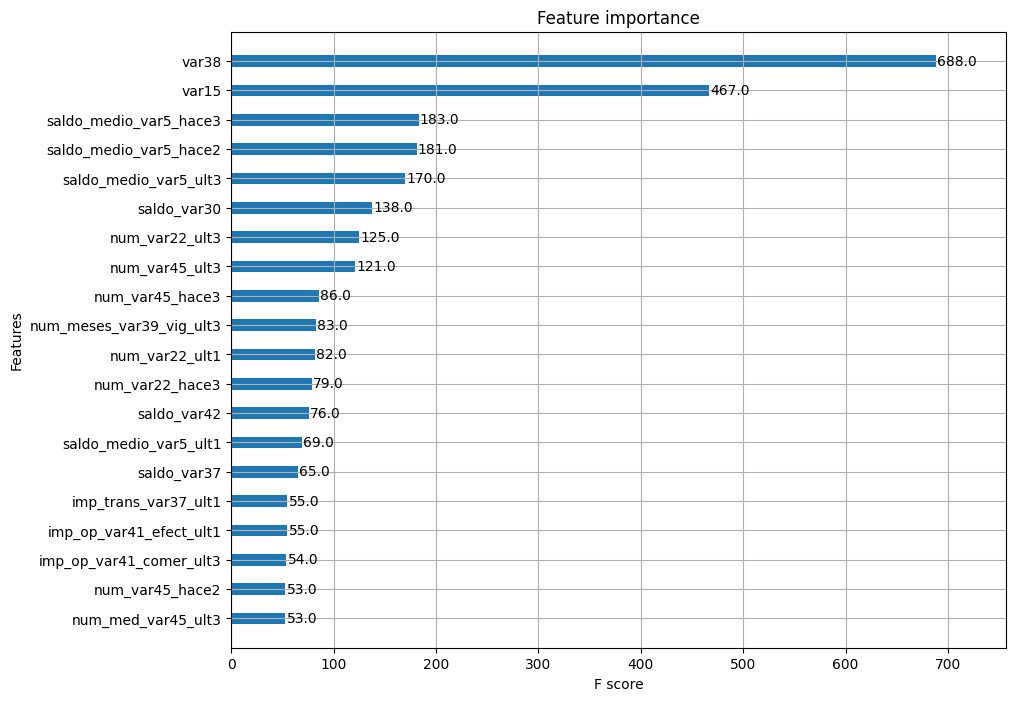

In [14]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1, figsize=(10,8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)

3. LightGBM 모델 학습과 하이퍼 파라미터 튜닝

In [15]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=500,
                          early_stopping_rounds=100,
                          eval_metric='auc')

eval_set=[(X_tr, y_tr),(X_val, y_val)]
lgbm_clf.fit(X_tr, y_tr, eval_set=eval_set)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 1658, number of negative: 40913
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.076453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13308
[LightGBM] [Info] Number of data points in the train set: 42571, number of used features: 242
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038947 -> initscore=-3.205836
[LightGBM] [Info] Start training from score -3.205836
Training un

In [16]:
# 검색 공간 설정

lgbm_search_space = {'num_leaves':hp.quniform('num_leaves',32,64,1),
                     'max_depth':hp.quniform('max_depth',100, 160,1),
                     'min_child_samples':hp.quniform('min_child_samples',60,100,1),
                    'subsample':hp.uniform('subsample',0.7,1),
                    'learning_rate':hp.uniform('learning_rate',0.01,0.2)}

In [17]:
# 목적 함수 생성

def objective_func(search_space):
  lgbm_clf = LGBMClassifier(n_estimators=100,
                            num_leaves=int(search_space['num_leaves']),
                            max_depth=int(search_space['max_depth']),
                          min_child_samples=int(search_space['min_child_samples']),
                          subsample=search_space['subsample'],
                          learning_rate=search_space['learning_rate'],
                          early_stopping_rounds= 30,
                          eval_metric="auc")

  # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
  roc_auc_list =[ ]

  # 3개 k-fold 방식 적용
  kf=KFold(n_splits=3)
  # X_train을 다시 학습과 검증용 데이터로 분리
  for tr_index, val_index in kf.split(X_train):
    # kf.split(X_train)으로 추출된 학습과 검증 index 값으로 학습, 검증 데이터세트 분리
    X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
    X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]

    # 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행
    lgbm_clf.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr),(X_val, y_val)])

    # 1로 예측한 확률값 추출 후 roc auc 계산, 평균 roc auc 계산을 위해 list에 결괏값 담음
    score = roc_auc_score(y_val, lgbm_clf.predict_proba(X_val)[:,1])
    roc_auc_list.append(score)

  #3개 k-fold로 계산된 roc_auc 값의 평균값을 반환화되,
  # HyperOpt는 목적함수의 최솟값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환.
  return -1*np.mean(roc_auc_list)

In [18]:
# 최적 하이퍼 파라미터 도출

from hyperopt import fmin, tpe, Trials

trials = Trials()

# fmin() 함수 호출, max_evals 지정된 횟수만큼 반복 후 목적함수의 최솟값을 가지는 최적 입력값 추출.
best = fmin(fn=objective_func,
            space=lgbm_search_space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials, rstate=np.random.default_rng(seed=30))

print('best:', best)

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 1579, number of negative: 38965
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12827
[LightGBM] [Info] Number of data points in the train set: 40544, number of used features: 192
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038945 -> initscore=-3.205872
[LightGBM] [Info] Start training from score -3.205872
Training until va

In [19]:
lgbm_clf = LGBMClassifier(n_estimators=500, num_leaves=int(best['num_leaves']),
                          max_depth=int(best['max_depth']),
                          min_child_samples=int(best['min_child_samples']),
                          subsample=best['subsample'],
                         learning_rate=round(best['learning_rate'],5),
                         early_stopping_rounds= 100,
                          eval_metric="auc")

lgbm_clf.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr),(X_val, y_val)])

lgbm_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 1658, number of negative: 40913
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12898
[LightGBM] [Info] Number of data points in the train set: 42571, number of used features: 192
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038947 -> initscore=-3.205836
[LightGBM] [Info] Start training from score -3.205836
Training un

## 신용카드 사기 검출

In [20]:
!pip install imbalanced-learn

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

card_df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


데이터 가공

In [22]:
from sklearn.model_selection import train_test_split

# time 칼럼 삭제 후 복사된 df 반환
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  df_copy.drop('Time', axis=1, inplace=True)
  return df_copy

In [39]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수
def get_train_test_dataset(df=None):
  # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
  df_copy = get_preprocessed_df(df)
  # DataFrame의 맨 마지막 칼럼이 레이블, 나머지는 피처들
  X_features = df_copy.iloc[:,:-1]
  y_target = df_copy.iloc[:,-1]
  # train_test_split()으로 학습과 테스트 데이터 분리. Stratified 기반 분할
  X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
  # 학습, 테스트 데이터셋 반환
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [40]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0]*100)
print('\n 테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0]*100)

학습 데이터 레이블 값 비율
Class
0    99.978399
1     0.021601
Name: count, dtype: float64

 테스트 데이터 레이블 값 비율
Class
0    99.977729
1     0.022271
Name: count, dtype: float64


모델 학습, 예측, 평가

In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix,f1_score,roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None): # ROC AUC는 예측 확률값 기반으로 계산 > 함수의 인자로 받을 수 있도록
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  # ROC-AUC 추가
  roc_auc = roc_auc_score(y_test, pred_proba)
  print('오차 행렬')
  print(confusion)
  # ROC-AUC print 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [42]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85293     2]
 [   18     1]]
정확도: 0.9998, 정밀도: 0.3333, 재현율: 0.0526, F1:0.0909, AUC:0.7733


In [43]:
# 인자로 사이킷런의 Estimator 객체와 학습, 테스트 데이터세트를 입력받아서 학습, 예측, 평가 수행
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
  model.fit(ftr_train, tgt_train)
  pred = model.predict(ftr_test)
  pred_proba = model.predict_proba(ftr_test)[:,1]
  get_clf_eval(tgt_test, pred, pred_proba)

In [44]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

[LightGBM] [Info] Number of positive: 43, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199063, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

데이터 분포도 변환 후 모델 학습, 예측, 평가

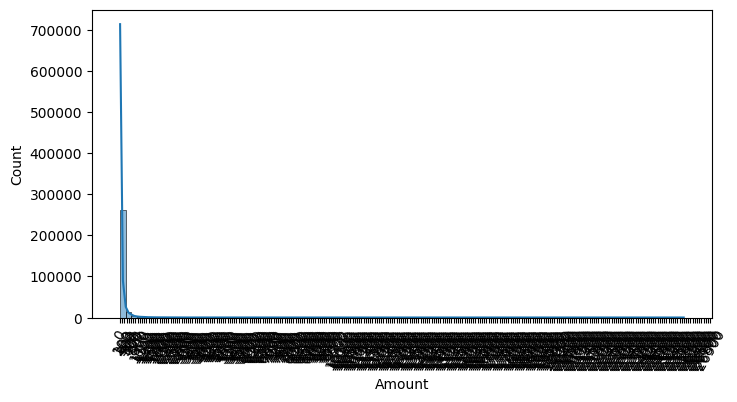

In [45]:
# Amount 피처 분포도 확인

import seaborn as sns

plt.figure(figsize=(8,4))
plt.xticks(range(0,30000,100), rotation=60)
sns.histplot(card_df['Amount'], bins=100, kde=True)
plt.show()

In [46]:
from sklearn.preprocessing import StandardScaler
# 사이킷런의 StandardScaler를 이용해 정규 분포 형태로 Amount 피처값 변환하는 로직으로 수정
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  scaler = StandardScaler()
  amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
  # 변환된 Amount를 Amount_Scaled로 피처명 변경후 DataFrame맨 앞 칼럼으로 입력
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  # 기존 Time, Amount 피처 삭제
  df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
  return df_copy

In [47]:
# Amount를 정규 분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('\n### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   55    93]]
정확도: 0.9992, 정밀도: 0.8692, 재현율: 0.6284, F1:0.7294, AUC:0.9706

### LightGBM 예측 성능 ###
[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

In [32]:
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  # 넘파이의 log1p()를 이용해 Amount를 로그 변환
  amount_n=np.log1p(df_copy['Amount'])
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
  return df_copy

In [33]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85282    13]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8725, 재현율: 0.6014, F1:0.7120, AUC:0.9734
### LightGBM 예측 성능 ###
[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

이상치 데이터 제거 후 모델 학습, 예측, 평가

<Axes: >

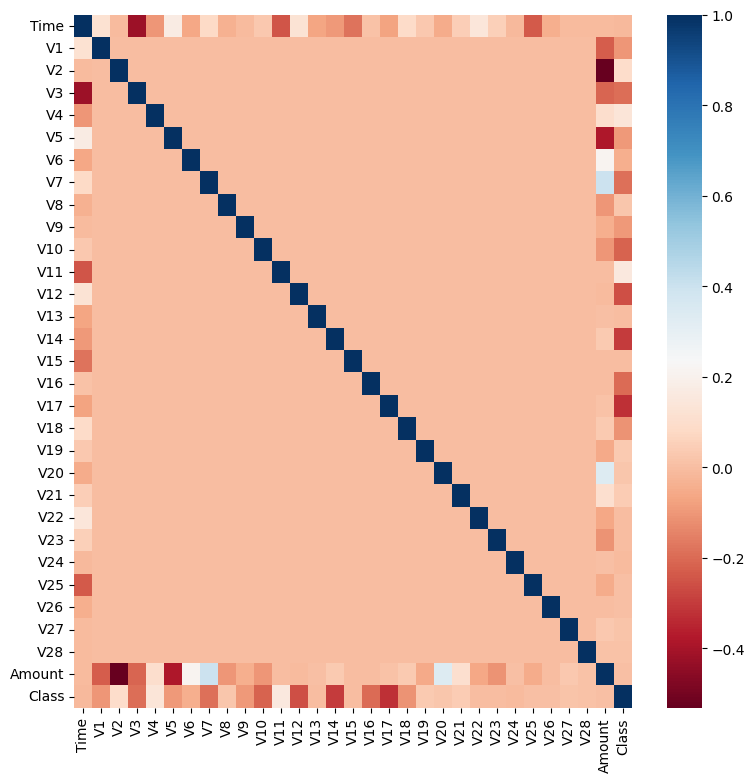

In [35]:
import seaborn as sns

plt.figure(figsize=(9,9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

In [48]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
  # 사기에 해당하는 칼럼데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함
  fraud=df[df['Class']==1][column]
  quantile_25 = np.percentile(df[column].values, 25)
  quantile_75 = np.percentile(df[column].values, 75)
  # IQR 구하고, 최댓값 최솟값 지점 구함
  iqr = quantile_75 - quantile_25
  iqr_weight = iqr * weight
  lowest_val = quantile_25 - iqr_weight
  highest_val = quantile_75 + iqr_weight
  outlier_index = fraud[(fraud < lowest_val)| (fraud > highest_val)].index
  return outlier_index

In [49]:
# V14 칼럼에서 이상치 데이터 찾기

outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Index([   541,   6108,   6329,   6331,   6334,   6336,   6338,   6427,   6446,
         6472,
       ...
       263877, 268375, 274475, 276071, 276864, 279863, 280143, 280149, 281144,
       281674],
      dtype='int64', length=430)


In [38]:
# get_preprocessed_df()에 get_outlier() 추가

def get_preprocessed_df(df=None):
  df_copy = df.copy()
  amount_n = np.log1p(df_copy['Amount'])
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
  # 이상치 데이터 삭제하는 로직 추가
  outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
  df_copy.drop(outlier_index, axis=0, inplace=True)
  return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print('\n### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85293     2]
 [   18     1]]
정확도: 0.9998, 정밀도: 0.3333, 재현율: 0.0526, F1:0.0909, AUC:0.7733

### LightGBM 예측 성능 ###
[LightGBM] [Info] Number of positive: 43, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199063, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

SMOTE 오버 샘플링 적용 후 모델 학습, 예측, 평가

In [50]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (199364, 29) (199364,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 Class
0    199020
1    199020
Name: count, dtype: int64


In [51]:
# 로지스틱 회귀 학습

lr_clf = LogisticRegression(max_iter=1000)

get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[83321  1974]
 [   15   133]]
정확도: 0.9767, 정밀도: 0.0631, 재현율: 0.8986, F1:0.1180, AUC:0.9797


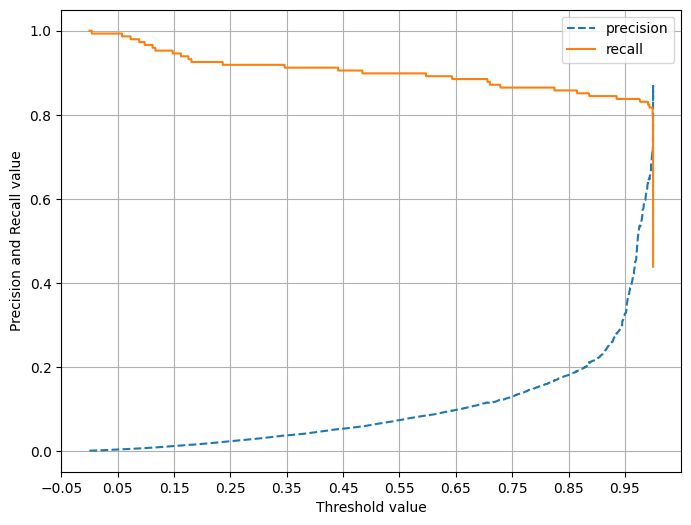

In [52]:
# 정밀도-재현율 곡선을 통해 문제점 시각화

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

from sklearn.metrics import precision_recall_curve

def precision_recall_curve_plot(y_test, pred_proba_c1):
  # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
  precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

  # X축 - 임곗값, Y축 - 정밀도, 재현율
  plt.figure(figsize=(8,6))
  threshold_boundary = thresholds.shape[0]
  plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
  plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')

  # threshold 값 X 축의 Scale을 0.1단위로 변경
  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start, end, 0.1),2))

  # x축, y축 label과 legend, 그리고 gird 설정
  plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
  plt.legend(); plt.grid()
  plt.show()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

In [53]:
# LightGBM 모델 학습

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

[LightGBM] [Info] Number of positive: 199020, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.241987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 398040, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split